In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from collections import defaultdict
from torchvision import transforms
import torch.nn.functional as F
#from torchvision import transforms
#from torchvision import models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Using device: cuda
Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/GBCUD/benign_gb_dataset"
valid_classes = [folder for folder in os.listdir(data_dir) if folder != "8_Carcinoma"]
valid_data = {folder: os.path.join(data_dir, folder) for folder in valid_classes}

In [8]:
# Dataset Preparation & Preprocessing

data_dir = "/content/drive/MyDrive/GBCUD/benign_gb_dataset"

# Exclude '8_Carcinoma' from the dataset
valid_classes = [folder for folder in os.listdir(data_dir) if folder != "8_Carcinoma"]
valid_data = {folder: os.path.join(data_dir, folder) for folder in valid_classes}

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Organize images by prefix for each class (e.g., 'a1', 'b2')
class_prefix_groups = {}
for class_name in valid_classes:
    class_path = os.path.join(data_dir, class_name)
    prefix_groups = defaultdict(list)
    for img_name in os.listdir(class_path):
        prefix = img_name.split(" ")[0]  # Extract prefix (e.g., 'a1', 'b2')
        prefix_groups[prefix].append(os.path.join(class_path, img_name))
    class_prefix_groups[class_name] = prefix_groups

# Splitting per class to maintain class balance
train_images, val_images, test_images = [], [], []
for class_name, prefix_groups in class_prefix_groups.items():
    prefix_ids = list(prefix_groups.keys())
    train_ids, test_ids = train_test_split(prefix_ids, test_size=0.15, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.176, random_state=42)  # 15% of total dataset is validation

    train_images.extend([img for prefix in train_ids for img in prefix_groups[prefix]])
    val_images.extend([img for prefix in val_ids for img in prefix_groups[prefix]])
    test_images.extend([img for prefix in test_ids for img in prefix_groups[prefix]])

# Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform):
      self.image_paths = image_paths
      self.transform = transform
      self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(valid_classes)}

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      label_name = os.path.basename(os.path.dirname(img_path))
      label = self.class_to_idx[label_name]

      image = cv2.imread(img_path)
      if image is None:
          print(f"Warning: Failed to read image {img_path}. Skipping...")
          return self.__getitem__((idx + 1) % len(self.image_paths))  # Get next image safely

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = transforms.ToPILImage()(image)
      image = self.transform(image)

      return image, label

In [6]:
print(valid_classes)
print(valid_data)

['1_Gallstones', '2_Abdomen and retroperitoneum', '3_cholecystitis', '4_Membranous and gangrenous cholecystitis', '5_Perforation', '6_Polyps and cholesterol crystals', '7_Adenomyomatosis', '9_Various causes of gallbladder wall thickening']
{'1_Gallstones': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones', '2_Abdomen and retroperitoneum': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/2_Abdomen and retroperitoneum', '3_cholecystitis': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/3_cholecystitis', '4_Membranous and gangrenous cholecystitis': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/4_Membranous and gangrenous cholecystitis', '5_Perforation': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/5_Perforation', '6_Polyps and cholesterol crystals': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/6_Polyps and cholesterol crystals', '7_Adenomyomatosis': '/content/drive/MyDrive/GBCUD/benign_gb_dataset/7_Adenomyomatosis', '9_Various causes of gallbladder wall thickening': '/c

In [9]:
# Create datasets
train_dataset = CustomImageDataset(train_images, transform)
val_dataset = CustomImageDataset(val_images, transform)
test_dataset = CustomImageDataset(test_images, transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Model

class Attention(nn.Module):
    def __init__(self, num_classes=8):
        super(Attention, self).__init__()
        self.L = 512  # Fully-connected layer size
        self.D = 128  # Attention layer size
        self.K = 1    # Number of attention heads

        resnet = models.resnet18(pretrained=True)
        # Remove the final fully-connected layer and later layers, keep convolutional features.
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((30, 30))  # Force feature maps to 30x30

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(512 * 30 * 30, self.L),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Linear(self.L * self.K, num_classes)

    def forward(self, x):
        B, bag_size, C, H, W = x.shape
        x = x.view(B * bag_size, C, H, W)
        features = self.feature_extractor(x)       # (B*bag_size, 512, H', W')
        features = self.pool(features)               # (B*bag_size, 512, 30, 30)
        features = features.view(B * bag_size, -1)     # (B*bag_size, 512*30*30)
        H_features = self.feature_extractor_part2(features)  # (B*bag_size, L)
        H_features = H_features.view(B, bag_size, -1)  # (B, bag_size, L)

        A = self.attention(H_features.view(B * bag_size, -1))  # (B*bag_size, K)
        A = A.view(B, bag_size, self.K).transpose(1, 2)         # (B, K, bag_size)
        A = F.softmax(A, dim=2)

        M = torch.bmm(A, H_features)  # (B, K, L)
        M = M.view(B, -1)             # (B, K*L)
        logits = self.classifier(M)
        probs = torch.softmax(logits, dim=1)
        return logits, probs, A

    def calculate_classification_error(self, X, Y):
        logits, _, _ = self.forward(X)
        preds = torch.argmax(logits, dim=1)
        error = 1.0 - preds.eq(Y).cpu().float().mean().item()
        return error, preds

    def calculate_objective(self, X, Y):
        logits, _, A = self.forward(X)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, Y)
        return loss, A

In [11]:
print(len(valid_classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

8


In [12]:
# Create an instance of the Attention model.
model = Attention(num_classes=len(valid_classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


In [13]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

In [14]:
print("Sample image paths:")
for i in range(5):
    print(train_images[i])

Sample image paths:
/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones/a2 (11).jpg
/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones/a2 (12).jpg
/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones/a2 (13).jpg
/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones/a2 (15).jpg
/content/drive/MyDrive/GBCUD/benign_gb_dataset/1_Gallstones/a2 (14).jpg


Epoch 1/50, Train Loss: 2.9073, Train Acc: 0.1503, Val Loss: 2.0710, Val Acc: 0.1490
Epoch 2/50, Train Loss: 1.9696, Train Acc: 0.1854, Val Loss: 2.0865, Val Acc: 0.1252
Epoch 3/50, Train Loss: 1.8437, Train Acc: 0.2793, Val Loss: 2.2775, Val Acc: 0.1133
Epoch 4/50, Train Loss: 1.7376, Train Acc: 0.3203, Val Loss: 2.2331, Val Acc: 0.1252
Epoch 5/50, Train Loss: 1.6737, Train Acc: 0.3478, Val Loss: 2.5584, Val Acc: 0.1054
Epoch 6/50, Train Loss: 1.6622, Train Acc: 0.3469, Val Loss: 2.3451, Val Acc: 0.1078
Epoch 7/50, Train Loss: 1.6173, Train Acc: 0.3647, Val Loss: 2.1239, Val Acc: 0.1300
Epoch 8/50, Train Loss: 1.5638, Train Acc: 0.3849, Val Loss: 2.1407, Val Acc: 0.1157
Epoch 9/50, Train Loss: 1.5398, Train Acc: 0.3940, Val Loss: 3.4487, Val Acc: 0.1276
Epoch 10/50, Train Loss: 1.5494, Train Acc: 0.3940, Val Loss: 2.3480, Val Acc: 0.1426
Epoch 11/50, Train Loss: 1.5773, Train Acc: 0.3843, Val Loss: 2.4576, Val Acc: 0.1030
Early stopping triggered.


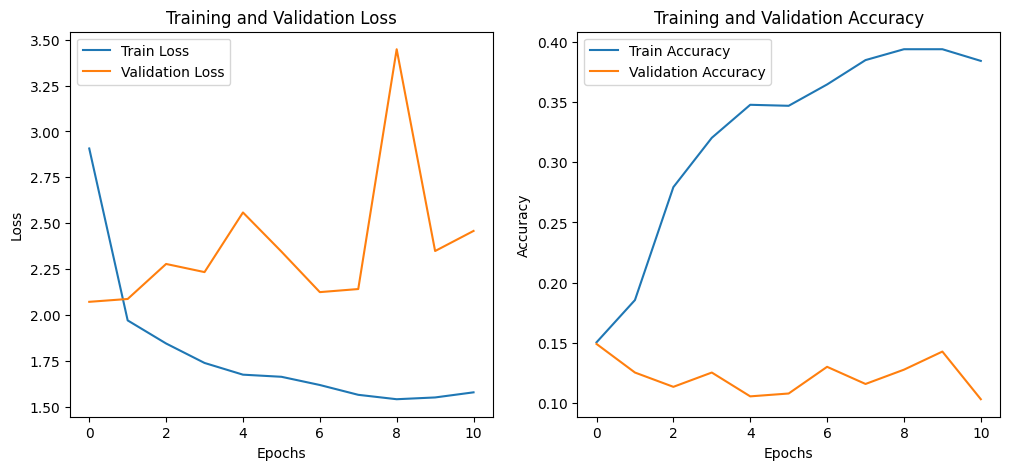

In [15]:
# Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = None

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # Now shape: (B, 1, 3, 224, 224)
            optimizer.zero_grad()
            logits, probs, A = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = train_correct / total_train

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.unsqueeze(1)  # (B, 1, 3, 224, 224)
                logits, probs, A = model(inputs)
                loss = criterion(logits, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 #10
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer)

Final Test Accuracy: 0.22505307855626328
Classification Report:
                                                  precision    recall  f1-score   support

                                   1_Gallstones       0.19      0.80      0.30       334
                  2_Abdomen and retroperitoneum       0.00      0.00      0.00       192
                                3_cholecystitis       0.00      0.00      0.00       192
      4_Membranous and gangrenous cholecystitis       0.00      0.00      0.00       422
                                  5_Perforation       0.26      0.36      0.31       192
              6_Polyps and cholesterol crystals       0.63      0.36      0.46       240
                              7_Adenomyomatosis       0.00      0.00      0.00       222
9_Various causes of gallbladder wall thickening       1.00      0.01      0.02        90

                                       accuracy                           0.23      1884
                                      macro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


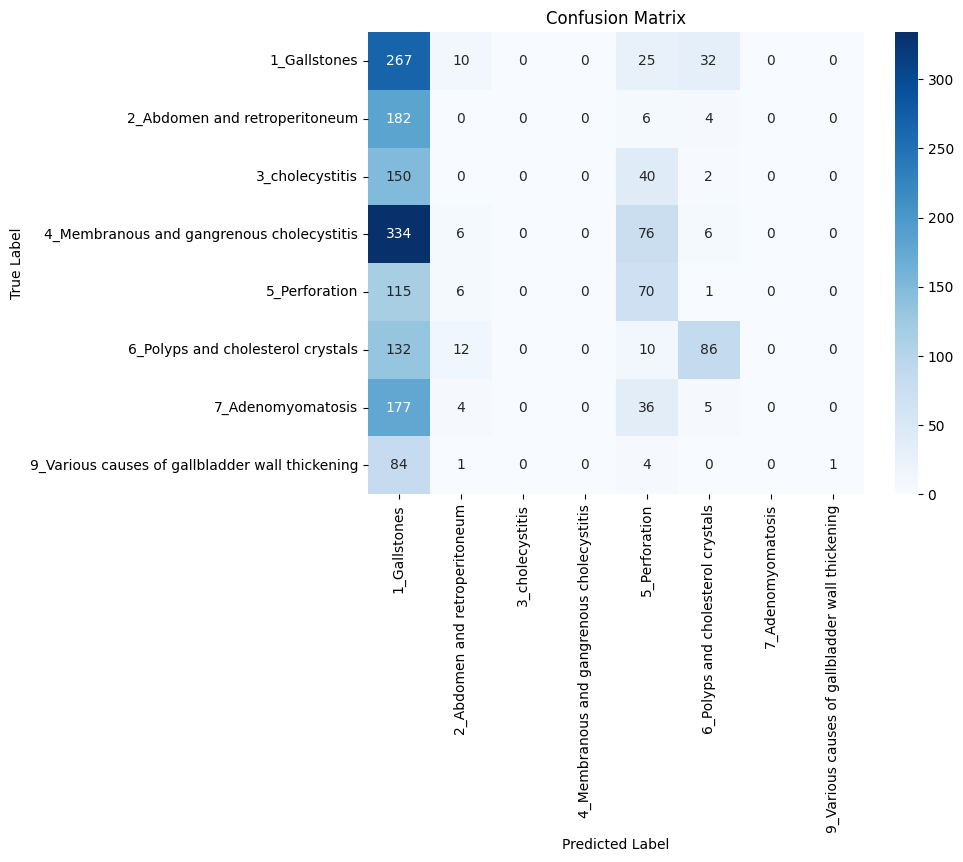

In [16]:
# Model Eval
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # (B, 1, 3, 224, 224)
            logits, probs, A = model(inputs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print("Final Test Accuracy:", acc)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=valid_classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=valid_classes, yticklabels=valid_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_loader)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Final Test Accuracy: 0.22505307855626328
Precision: 0.2599766525336206
Recall: 0.19167862192282104
F1 Score: 0.13566009926967287
Classification Report:
                                                  precision    recall  f1-score   support

                                   1_Gallstones       0.19      0.80      0.30       334
                  2_Abdomen and retroperitoneum       0.00      0.00      0.00       192
                                3_cholecystitis       0.00      0.00      0.00       192
      4_Membranous and gangrenous cholecystitis       0.00      0.00      0.00       422
                                  5_Perforation       0.26      0.36      0.31       192
              6_Polyps and cholesterol crystals       0.63      0.36      0.46       240
                              7_Adenomyomatosis       0.00      0.00      0.00       222
9_Various causes of gallbladder wall thickening       1.00      0.01      0.02        90

                                       accur

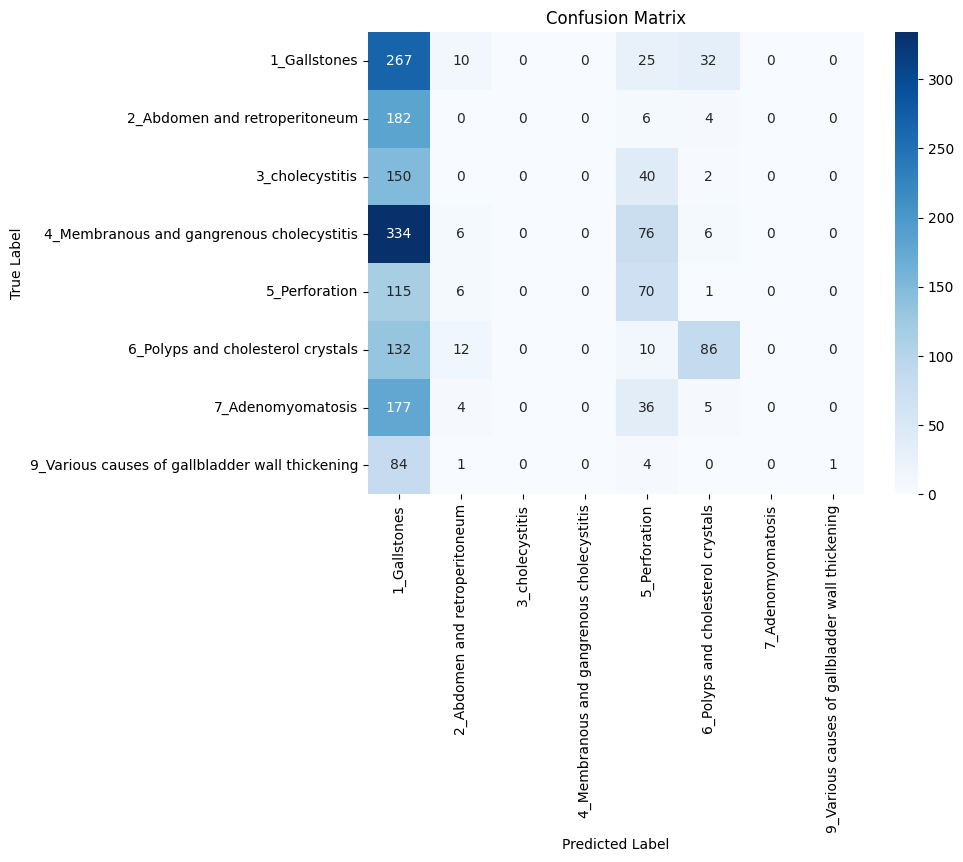

AttributeError: 'Attention' object has no attribute 'layer4'

In [17]:
# Grad-CAM
def compute_gradcam(model, image, class_idx):
    model.eval()
    image = image.unsqueeze(0).to(device)

    feature_maps = []
    gradients = []

    def forward_hook(module, input, output):
        feature_maps.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    model.layer4[-1].register_forward_hook(forward_hook)
    model.layer4[-1].register_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    target = output[0, class_idx]
    target.backward()

    grad = gradients[0].cpu().data.numpy()
    fmap = feature_maps[0].cpu().data.numpy()

    weights = np.mean(grad, axis=(2, 3), keepdims=True)
    cam = np.sum(weights * fmap, axis=1)
    cam = np.maximum(cam, 0)
    cam = cam[0]
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # (B, 1, 3, 224, 224)
            logits, probs, A = model(inputs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print("Final Test Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=valid_classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=valid_classes, yticklabels=valid_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    for i in range(5):
        image, label = test_dataset[i]
        cam = compute_gradcam(model, image, all_preds[i])
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title(f"Grad-CAM for {valid_classes[all_preds[i]]}")
        plt.show()

evaluate_model(model, test_loader)

In [ ]:
# Save the trained model
# save_path = '/content/drive/MyDrive/GBCUD/benign_classifier_prototypes/prototype1.pth'
# torch.save(model.state_dict(), save_path)
# print(f"Model saved to {save_path}")